In [1]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 420 (delta 12), reused 9 (delta 2), pack-reused 393 (from 1)
Receiving objects: 100% (420/420), 22.56 MiB | 22.94 MiB/s, done.
Resolving deltas: 100% (270/270), done.
/content/ELENA
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.8 MB/s eta 0:00:00


In [2]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [3]:
%%writefile /content/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

# Entropy density of the SM plasma (approximate, constant g_star)
g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Writing /content/utils.py


In [4]:
%%writefile /content/ELENA/src/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Overwriting /content/ELENA/src/utils.py


In [5]:
%%writefile potential_3d.py
import numpy as np

# ---------- numerically safe helpers ----------
def _rtabs(x, floor=1e-30):
    """sqrt(|x|) with a tiny floor (keeps logs/ratios finite but preserves cancellations)."""
    return np.sqrt(np.maximum(np.abs(x), floor))

def _logsafe(x):
    return np.log(np.clip(np.abs(x), 1e-30, None))

# ---------- 4D input couplings ----------
g1_4   = 0.54
lam_4  = 1.65e-3
m0sq_4 = -(130.0**2)
Yphi   = 1.0

# ---------- thermal matching (placeholder; swap with DRalgo) ----------
cT   = 0.30*(g1_4**2) + 0.10*lam_4
c_mu = 1.0

def match_3d_params(T):
    T = float(T)
    g1sq_3 = (g1_4**2) * T           # [mass]^1
    lam_3  = lam_4 * T               # [mass]^1
    msq_3  = m0sq_4 + cT * T*T       # [mass]^2
    mu3US  = c_mu * max(g1_4*T, 1.0) # keep >0 at very low T
    return g1sq_3, lam_3, msq_3, mu3US

# ---------- stable small-ϕ handling for the three blocks ----------
def _MG_abs(phi, g1sq):
    # exact |ϕ| dependence prevents spurious constant pieces in logs
    return np.abs(phi) * np.sqrt(np.maximum(g1sq * (Yphi**2), 1e-30))

def _N_block1(phi, g1sq, lam, msq, mu3US):
    pi2  = np.pi**2
    phi2 = phi*phi
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    term1 =  (g1sq**2)*(Yphi**4)*phi2**2 / (8.0*pi2)
    term2 = -(g1sq*(Yphi**2)*phi2*(-msq + 2.0*g1sq*(Yphi**2)*phi2 - 3.0*lam*phi2)) / (16.0*pi2)
    term3 =  (g1sq*(Yphi**2)*phi2*MG*M3) / (8.0*pi2)
    term4 = - ((msq + 3.0*lam*phi2)**2) * (0.5 + _logsafe(mu3US / M3)) / (16.0*pi2)
    tmp   = (-msq + g1sq*(Yphi**2)*phi2 - 3.0*lam*phi2)
    term5 =  (tmp*tmp) * (0.5 + _logsafe(mu3US / (MG + M3))) / (8.0*pi2)
    term6n = ( 7.0*(g1sq**2)*(Yphi**4)*phi2**2 + tmp*tmp - 2.0*g1sq*(Yphi**2)*phi2*(msq + 3.0*lam*phi2) )
    term6  = - term6n * (0.5 + _logsafe(mu3US / (2.0*MG + M3))) / (16.0*pi2)
    return term1 + term2 + term3 + term4 + term5 + term6

def _N_block2(phi, g1sq, lam, msq, mu3US):
    pi   = np.pi
    pi2  = pi**2
    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    t1 = - (MG * (g1sq*(Yphi**2)*phi2 - 2.0*lam*phi2) * M1) / (16.0*pi2)
    t2 =  (M3 / (4.0*pi)) * ((g1sq*(Yphi**2)*phi2*M1)/(4.0*pi)
                             - (MG*(g1sq*(Yphi**2)*phi2 + 2.0*lam*phi2))/(4.0*pi))
    t3 =  (lam**2 * phi2**2) * (0.5 + _logsafe(mu3US / (M1 + M3))) / (4.0*pi2)
    num = ( (g1sq**2)*(Yphi**4)*phi2**2 + 4.0*lam**2*phi2**2
          - 2.0*g1sq*(Yphi**2)*phi2*(2.0*msq + 4.0*lam*phi2) )
    t4 = - num * (0.5 + _logsafe(mu3US / (MG + M1 + M3))) / (16.0*pi2)
    return t1 + t2 + t3 + t4

def _N_block3(phi, g1sq, lam, msq, mu3US):
    pi   = np.pi
    pi2  = pi**2
    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    t1 = - (MG * (g1sq*(Yphi**2)*phi2 + 2.0*lam*phi2) * M3) / (16.0*pi2)
    t2 =  (M1 / (4.0*pi)) * ( - (MG * (g1sq*(Yphi**2)*phi2 - 2.0*lam*phi2)) /(4.0*pi)
                               + (g1sq*(Yphi**2)*phi2*M3) / (4.0*pi) )
    t3 =  (lam**2 * phi2**2) * (0.5 + _logsafe(mu3US / (M1 + M3))) / (4.0*pi2)
    num = ( (g1sq**2)*(Yphi**4)*phi2**2 + 4.0*lam**2*phi2**2
          - 2.0*g1sq*(Yphi**2)*phi2*(2.0*msq + 4.0*lam*phi2) )
    t4 = - num * (0.5 + _logsafe(mu3US / (MG + M1 + M3))) / (16.0*pi2)
    return t1 + t2 + t3 + t4

def _block_stable(phi, g1sq, lam, msq, mu3US, Nfunc, phi_cut=1e-2, h_abs=1e-4):
    """
    Stable evaluation of N(phi)/(4 phi^2):
      if |phi|>=phi_cut -> direct ratio
      else -> even-limit via symmetric second-difference using a fixed |h| (not ∝phi)
    """
    phi = float(phi)
    if abs(phi) >= phi_cut:
        return Nfunc(phi, g1sq, lam, msq, mu3US) / (4.0 * phi*phi)
    h = h_abs
    Nhp = Nfunc(+h, g1sq, lam, msq, mu3US)
    Nhm = Nfunc(-h, g1sq, lam, msq, mu3US)
    a   = (Nhp + Nhm) / (2.0 * h*h)  # coefficient of phi^2 in N(phi)
    return 0.25 * a

# ---------- Effective potential ----------
def V(phi, T):
    phi = np.asarray(phi, dtype=float)
    T   = np.asarray(T,   dtype=float)

    g1sq, lam, msq, mu3US = match_3d_params(T)
    g1sq  = np.asarray(g1sq,  dtype=float)
    lam   = np.asarray(lam,   dtype=float)
    msq   = np.asarray(msq,   dtype=float)
    mu3US = np.asarray(mu3US, dtype=float)

    pi  = np.pi
    pi2 = pi**2

    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    term_tree  = 0.5 * msq * phi2 + 0.25 * lam * phi2**2
    term_cg    = - (MG**3) / (6.0 * pi)
    term_c1    =  (g1sq * (Yphi**2) * MG * M1) / (16.0 * pi2)
    term_l1    =  (3.0 * lam * (msq + lam * phi2)) / (64.0 * pi2)
    term_sc1   = - (M1**3) / (12.0 * pi)
    term_c2    =  (g1sq * (Yphi**2) * MG * M3) / (16.0 * pi2)
    term_mix   =  (lam * M1 * M3) / (32.0 * pi2)
    term_l2    =  (3.0 * lam * (msq + 3.0 * lam * phi2)) / (64.0 * pi2)
    term_sc2   = - (M3**3) / (12.0 * pi)
    term_log_scalar = - (3.0 * lam**2 * phi2) / (16.0 * pi2) * (0.5 + _logsafe(mu3US / (3.0 * M3)))
    term_last       = - (lam**2 * phi2) / (16.0 * pi2) * (0.5 + _logsafe(mu3US / (2.0 * M1 + M3)))

    # stabilized blocks (vectorized over phi)
    b1 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block1)
    b2 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block2)
    b3 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block3)

    return term_tree + term_cg + term_c1 + term_l1 + term_sc1 + term_c2 + term_mix + term_l2 + term_sc2 + term_log_scalar + b1 + b2 + b3 + term_last

def dV(phi, T):
    phi = np.asarray(phi, dtype=float)
    # step independent of phi near zero → stable with |ϕ| cusps
    h = 1e-3 * np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)


Writing potential_3d.py


In [6]:
%%writefile custom_model.py
from potential_3d import V as V_raw, dV as dV_raw

class CustomModel:
    """
    Minimal drop-in replacement for `model`:
    exposes DVtot and gradV, wrapping your custom V and dV.
    """
    def __init__(self, vev, lambda_, g, xstep, Tstep, units="MeV"):
        self.vev     = vev
        self.lambda_ = lambda_
        self.g       = g
        self.xstep   = xstep
        self.Tstep   = Tstep
        self.units   = units

        # If you want rescaling by units, do it here.
        # For now: just pass through to your potential.
        self.DVtot = lambda phi, T: V_raw(phi, T)
        self.gradV = lambda phi, T: dV_raw(phi, T)


Writing custom_model.py


In [7]:
import numpy as np
from utils import convert_units
from custom_model import CustomModel  # instead of `from model import model`

# You can still choose units randomly if you like
units = np.random.choice(list(convert_units.keys()))

# Parameters
lambda_ = 1.65e-3
g       = 0.54
vev, units = 500, "MeV"
description = "Fast"

# Construct "model" using your custom potential
dp = CustomModel(vev, lambda_, g,
                 xstep = vev * 1e-3,
                 Tstep = vev * 1e-3,
                 units = units)

V  = dp.DVtot   # this now points to your big V(phi,T)
dV = dp.gradV   # this now points to your big dV(phi,T)

print(f"lambda = {lambda_}")
print(f"g      = {g}")
print(f"vev    = {vev} {units}")

"""  quick sanity check:
phi_test = 10.0
T_test   = 200.0
print("V(10, 200) =", V(phi_test, T_test))
print("dV(10, 200) =", dV(phi_test, T_test)) """


lambda = 0.00165
g      = 0.54
vev    = 500 MeV


'  quick sanity check:\nphi_test = 10.0\nT_test   = 200.0\nprint("V(10, 200) =", V(phi_test, T_test))\nprint("dV(10, 200) =", dV(phi_test, T_test)) '

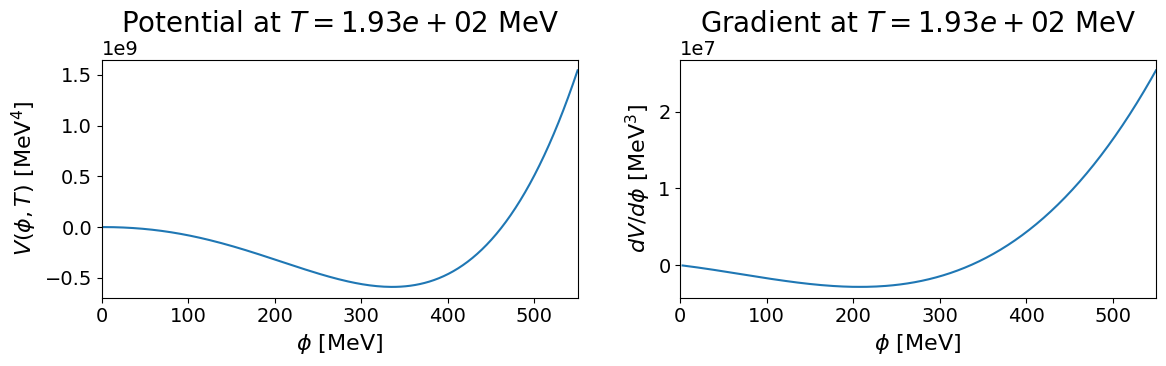

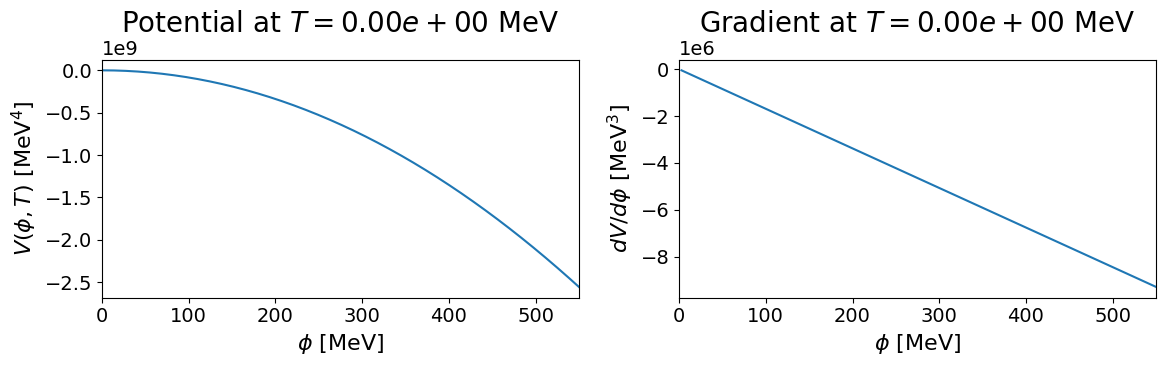

In [8]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

# Set global font size parameters
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20,
    'text.usetex': False    # <<< IMPORTANT for Colab
})

T = np.random.uniform(0, vev)

phi = np.linspace(0, 1.1 * vev, 200)
phi = phi.reshape(-1,1)

for t in [T, 0]:
    v = V(phi, t)
    dv = dV(phi, t)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(phi, v)
    axes[0].set_title(f"Potential at $T = {t:.2e}$ {units}")
    axes[0].set_xlabel(f"$\\phi$ [{units}]")
    axes[0].set_ylabel(f"$V(\\phi, T)$ [{units}$^4$]")

    axes[1].plot(phi[1:], dv[1:])
    axes[1].set_title(f"Gradient at $T = {t:.2e}$ {units}")
    axes[1].set_xlabel(f"$\\phi$ [{units}]")
    axes[1].set_ylabel(f"$dV/d\\phi$ [{units}$^3$]")

    for ax in axes:
        ax.set_xlim(phi[0], phi[-1])

    plt.tight_layout()
    plt.show()



In [9]:
import importlib, sys

# Make sure both locations are on the path
sys.path.insert(0, "/content")
sys.path.insert(0, "/content/ELENA/src")

import utils
importlib.reload(utils)


<module 'utils' from '/content/ELENA/src/utils.py'>

In [10]:
print("utils module path:", utils.__file__)
print("has s_SM?", hasattr(utils, "s_SM"))


utils module path: /content/ELENA/src/utils.py
has s_SM? True


In [11]:
from potential_3d import V, dV
from temperatures import find_T_min, find_T_max, refine_Tmin
import numpy as np


/usr/local/lib/python3.12/dist-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(f1, 0, abs(theta)**.5)[0]


In [44]:
%%writefile veff_4d.py
"""
veff_4d.py – 4D one-loop + high-T thermal potential for the Abelian–Higgs model.

This is a *different method* from your 3D DR potential:
 - works directly in 4D
 - uses Landau gauge and a simple high-T expansion
 - includes bosonic thermal masses but no dimensional reduction / DR resummation

It shares the SAME 4D parameters (g, lambda, m0^2) so that
you can isolate pure method dependence.
"""

import numpy as np

# ---------- 4D input couplings (same as in veff_elena / potential_3d) ----------
g4    = 0.54         # gauge coupling
lam4  = 1.65e-3      # quartic
m0sq4 = -(130.0**2)  # bare mass^2
Yphi  = 1.0          # U(1) charge of scalar

# ---------- mass spectra (Landau gauge, tree level) ----------

def m_h2(phi):
    """Higgs mass^2: m^2 + 3 λ φ^2."""
    return m0sq4 + 3.0*lam4*phi*phi

def m_G2(phi):
    """Goldstone mass^2: m^2 + λ φ^2 (Landau gauge)."""
    return m0sq4 + lam4*phi*phi

def m_A2(phi):
    """Gauge boson mass^2: g^2 Y^2 φ^2."""
    return (g4*Yphi)**2 * phi*phi

# Degeneracy factors (d.o.f.) – you can tweak if you want
n_h = 1.0   # one real Higgs
n_G = 1.0   # one real Goldstone
n_A = 3.0   # 3 polarisations of massive vector (roughly)

# ---------- tree-level potential ----------

def V_tree(phi):
    """Tree-level scalar potential in 4D."""
    return 0.5*m0sq4*phi*phi + 0.25*lam4*(phi**4)


# ---------- high-T bosonic thermal piece ----------

def V_T_boson(m2, n, T):
    """
    High-T expansion of bosonic thermal potential (keeping T^2 and cubic term):

    ΔV_T ≈ n * [ (m^2 T^2)/24  -  (m^3 T)/(12π) ]

    Constant -π^2 T^4/90 and logarithmic m^4 ln(m^2/T^2) terms are dropped
    because they are φ-independent or subleading for our comparison goal.
    """
    T = float(T)
    m2 = np.asarray(m2, dtype=float)
    m2_clip = np.maximum(m2, 0.0)   # avoid sqrt of negative
    m  = np.sqrt(m2_clip)

    term_T2 = (m2 * (T**2)) / 24.0
    term_T3 = - (m**3 * T) / (12.0 * np.pi)

    return n * (term_T2 + term_T3)


# ---------- full 4D one-loop + thermal effective potential ----------

def V(phi, T):
    """
    4D one-loop + thermal potential V_4D(φ,T) in high-T approximation.

    This is METHOD 2 (4D) to compare with your 3D DR potential.
    """
    phi = np.asarray(phi, dtype=float)
    T   = float(T)

    # tree level
    V0 = V_tree(phi)

    # masses
    mh2 = m_h2(phi)
    mG2 = m_G2(phi)
    mA2 = m_A2(phi)

    # thermal pieces (bosons only)
    VTh = V_T_boson(mh2, n_h, T)
    VTG = V_T_boson(mG2, n_G, T)
    VTA = V_T_boson(mA2, n_A, T)

    return V0 + VTh + VTG + VTA


# ---------- numerical derivative dV/dφ ----------

def dV(phi, T):
    """
    Numerical derivative dV/dφ using a symmetric finite difference.

    Step size is independent of φ near zero to stay stable with |φ| cusps.
    """
    phi = np.asarray(phi, dtype=float)
    T   = float(T)
    h = 1e-3 * np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)


if __name__ == "__main__":
    # quick sanity print
    Ts = [0.0, 50.0, 100.0, 150.0, 200.0]
    for T in Ts:
        for ph in [0.0, 10.0, 50.0, 200.0]:
            print(f"T={T:6.1f}, phi={ph:7.2f}, V4D={V(ph,T): .4e}, dV4D={dV(ph,T): .4e}")
        print("-"*50)


Writing veff_4d.py


In [45]:
import numpy as np
import matplotlib.pyplot as plt

from potential_3d import V as V_DR, dV as dV_DR    # your 3D DR potential
from veff_4d   import V as V_4D, dV as dV_4D    # new 4D potential


In [126]:
def compare_DR_vs_4D_multi(phi, Ts, units=r"\mathrm{MeV}"):


    import numpy as np
    import matplotlib.pyplot as plt

    plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,  # True if you have LaTeX in your environment
})


    # Ensure phi is 1D for plotting
    phi = np.asarray(phi).reshape(-1)

    # Round temperatures for nice labels
    Ts = np.asarray(Ts, dtype=float)
    Ts_round = Ts.astype(int)

    # Figure & axes
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Nice global style tweaks
    for ax in axes.flat:
        ax.tick_params(direction="in", top=True, right=True)
        ax.grid(alpha=0.25)

    # Colour map: same colour for a given T (solid=DR, dashed=4D)
    colors = plt.cm.viridis(np.linspace(0, 1, len(Ts_round)))

    for T, Tlab, color in zip(Ts, Ts_round, colors):
        V1  = V_DR(phi, T)
        V2  = V_4D(phi, T)
        dV1 = dV_DR(phi, T)
        dV2 = dV_4D(phi, T)

        dVpot = V1 - V2
        dGrad = dV1 - dV2

        # --- Potentials ---
        axes[0, 0].plot(phi, V1,  color=color, ls="-",
                        label=rf"DR, $T={Tlab}$")
        axes[0, 0].plot(phi, V2,  color=color, ls="--",
                        label=rf"4D, $T={Tlab}$")

        # --- ΔV ---
        axes[0, 1].plot(phi, dVpot, color=color,
                        label=rf"$T={Tlab}$")

        # --- Gradients ---
        axes[1, 0].plot(phi, dV1, color=color, ls="-",
                        label=rf"DR, $T={Tlab}$")
        axes[1, 0].plot(phi, dV2, color=color, ls="--",
                        label=rf"4D, $T={Tlab}$")

        # --- Δ(dV) ---
        axes[1, 1].plot(phi, dGrad, color=color,
                        label=rf"$T={Tlab}$")

    # Horizontal zero lines for the difference plots
    axes[0, 1].axhline(0.0, ls="--", color="grey", lw=1)
    axes[1, 1].axhline(0.0, ls="--", color="grey", lw=1)

    # Titles and axis labels
    axes[0, 0].set_title(r"$V_{\mathrm{eff}}(\phi, T)$")
    axes[0, 1].set_title(r"$\Delta V(\phi, T) = V_{\rm DR} - V_{\rm 4D}$")
    axes[1, 0].set_title(r"$\partial_\phi V_{\mathrm{eff}}(\phi, T)$")
    axes[1, 1].set_title(r"$\Delta(\partial_\phi V) = \partial_\phi V_{\rm DR} - \partial_\phi V_{\rm 4D}$")

    axes[1, 0].set_xlabel(r"$\phi\ [{"+units+"}]$")
    axes[1, 1].set_xlabel(r"$\phi\ [{"+units+"}]$")

    axes[0, 0].set_ylabel(r"$V_{\mathrm{eff}}\ [{"+units+r"}^4]$")
    axes[0, 1].set_ylabel(r"$\Delta V\ [{"+units+r"}^4]$")
    axes[1, 0].set_ylabel(r"$\partial_\phi V\ [{"+units+r"}^3]$")
    axes[1, 1].set_ylabel(r"$\Delta(\partial_\phi V)\ [{"+units+r"}^3]$")

    # Legends (smaller, non-overlapping)
    axes[0, 0].legend(frameon=False, fontsize=11, ncol=2)
    axes[0, 1].legend(frameon=False, fontsize=11)
    axes[1, 0].legend(frameon=False, fontsize=11, ncol=2)
    axes[1, 1].legend(frameon=False, fontsize=11)

    plt.tight_layout()
    plt.show()


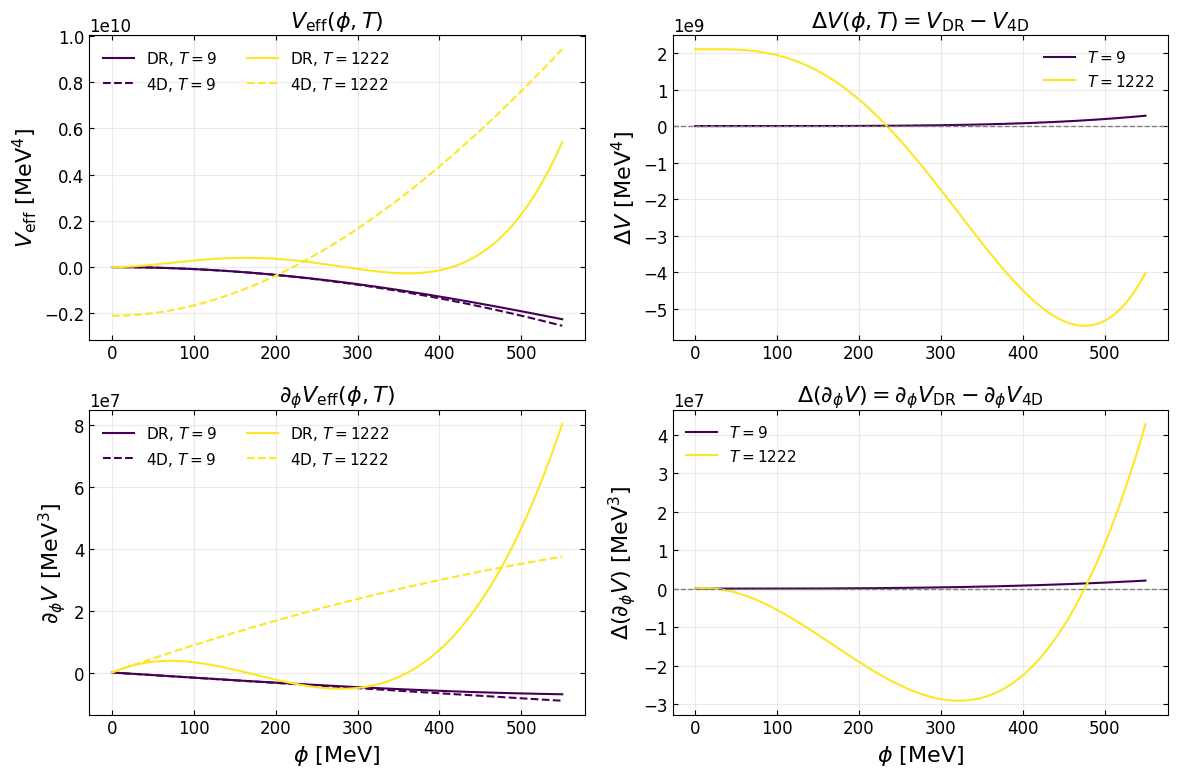

In [193]:
phi = np.linspace(0, 1.1*vev, 2601)
phi = phi.reshape(-1,1)
Ts  = np.random.uniform(0, 2.5*vev, size=2)
Ts = np.round(Ts).astype(int)
compare_DR_vs_4D_multi(phi, Ts)
